In [18]:
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [19]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# === Step 1: Load Dataset from Folders === #
img_size = 224
batch_size = 32
train_dir = r"C:\Users\Admin\Desktop\Samiksha\cognize hackathon\data3a\training"  # Change this to your dataset path

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

# === Step 2: Load MobileNetV2 Model === #
base_model = tf.keras.applications.MobileNetV2(
    weights=None,  # No pre-trained weights
    include_top=False,
    input_shape=(img_size, img_size, 3)
)

# === Step 3: Add Custom Layers === #
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(3, activation="softmax")(x)  # 3 damage severity classes

model = Model(inputs=base_model.input, outputs=x)

# Compile Model
model.compile(
    optimizer="adam", 
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 
    metrics=["accuracy"]
)

# === Step 4: Train Model === #
epochs = 23  # Increase if needed
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs)


# === Step 5: Save Model === #
model.save('my_model.keras')  

print("Model trained and saved!")



Found 1108 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/23
35/35 ━━━━━━━━━━━━━━━━━━━━ 213s 5s/step - accuracy: 0.3830 - loss: 1.1753 - val_accuracy: 0.3345 - val_loss: 1.0988
Epoch 2/23
35/35 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - accuracy: 0.5316 - loss: 1.0254 - val_accuracy: 0.3345 - val_loss: 1.0993
Epoch 3/23
35/35 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.5791 - loss: 0.9550 - val_accuracy: 0.3273 - val_loss: 1.0990
Epoch 4/23
35/35 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.5939 - loss: 0.9299 - val_accuracy: 0.3345 - val_loss: 1.0999
Epoch 5/23
35/35 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.6495 - loss: 0.8360 - val_accuracy: 0.3345 - val_loss: 1.1042
Epoch 6/23
35/35 ━━━━━━━━━━━━━━━━━━━━ 163s 5s/step - accuracy: 0.6326 - loss: 0.8462 - val_accuracy: 0.3345 - val_loss: 1.1068
Epoch 7/23
35/35 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.6891 - loss: 0.7915 - val_accuracy: 0.3345 - val_loss: 1.1186
Epoch 8/23
35/35 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.7369 - loss: 0.7342 - val_accuracy: 0.3273 - v

In [20]:
import tensorflow.keras.backend as K

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        cross_entropy = K.categorical_crossentropy(y_true, y_pred)
        weights = alpha * K.pow((1 - y_pred), gamma)
        return K.mean(weights * cross_entropy)
    return loss

model.compile(optimizer="adam", loss=focal_loss(), metrics=["accuracy"])


In [21]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path, img_size=224):
    img = image.load_img(img_path, target_size=(img_size, img_size))  # Load image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    return img_array


In [22]:
import os
from sklearn.metrics import classification_report

# Load trained model
model = tf.keras.models.load_model("car_damage_model.keras")

y_true = []  # True labels
y_pred = []  # Model predictions

# Define class names (same order as in training)
class_names = ["Severe", "Moderate", "Minor"]
class_folders = ["03-severe", "02-moderate", "01-minor"]  # Ensure correct order

# Loop through validation set
validation_path = r"C:\Users\Admin\Desktop\Samiksha\cognize hackathon\data3a\validation"  # Update with actual path
for idx, cls in enumerate(class_folders):
    img_folder = os.path.join(validation_path, cls)
    
    for img_name in os.listdir(img_folder):
        img_path = os.path.join(img_folder, img_name)
        
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Filter valid images
            img_array = preprocess_image(img_path)  # Preprocess
            preds = model.predict(img_array)  # Predict
            y_pred.append(np.argmax(preds[0]))  # Get class index
            y_true.append(idx)  # True label

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 318 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Raw Predictions: [[0.72518903 0.15687324 0.11793776]]
Prediction Probabilities: [0.72518903 0.15687324 0.11793776]
Predicted Class: 0


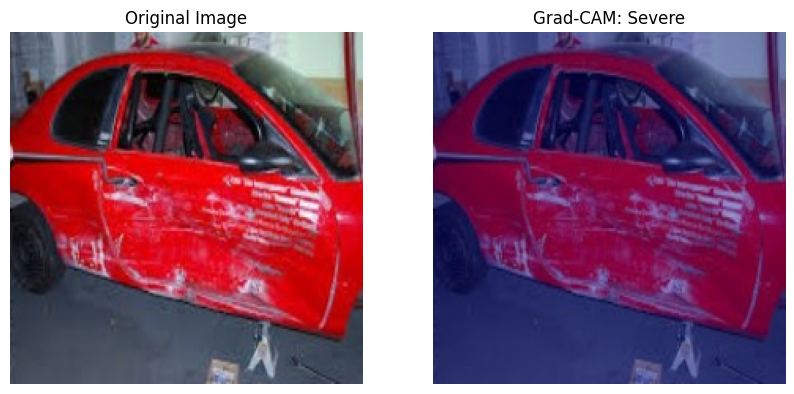

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from PIL import Image
import os

# === Step 6: Grad-CAM for Localization === #
def generate_gradcam(model, img_path, layer_name="block_13_expand"):  # Changed layer name
    img_size = 224

    # Load & preprocess image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Get last convolutional layer
    last_conv_layer = model.get_layer(layer_name)

    # Define Grad-CAM model
    grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        pred_class = tf.argmax(predictions[0])
        loss = predictions[:, pred_class]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Generate heatmap
    conv_output = conv_output[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    # Generate prediction probabilities
    preds = model.predict(img_array)

    # Print raw predictions for debugging
    print("Raw Predictions:", preds)

    # Check if any class dominates the prediction
    print("Prediction Probabilities:", preds[0])

    # Get the predicted class
    predicted_class = np.argmax(preds[0])
    print("Predicted Class:", predicted_class)


    return heatmap, predictions.numpy()

# Example Usage for Grad-CAM
try:
    img_path = r'C:\Users\Admin\Desktop\Samiksha\cognize hackathon\data3a\validation\03-severe\0005.JPEG'
    
    # Check if the image exists
    if not os.path.exists(img_path):
        raise FileNotFoundError("Image path is incorrect!")

    model_path = "car_damage_model.h5"
    
    # Check if the model file exists
    if not os.path.exists(model_path):
        raise FileNotFoundError("Model file not found!")

    model = tf.keras.models.load_model(model_path)

    heatmap, preds = generate_gradcam(model, img_path)

    # Load original image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("cv2.imread() failed. Check the image file format.")

    img = cv2.resize(img, (224, 224))

    # Resize heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay heatmap on image
    alpha = 0.4
    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)

    # Display results
    severity_classes = ["Severe", "Moderate", "Minor"]
    predicted_class = np.argmax(preds[0])
    predicted_label = severity_classes[predicted_class]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Grad-CAM: {predicted_label}')
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"Error: {str(e)}")


In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=["Severe", "Moderate", "Minor"]))


              precision    recall  f1-score   support

      Severe       0.37      1.00      0.54        91
    Moderate       0.00      0.00      0.00        75
       Minor       0.00      0.00      0.00        82

    accuracy                           0.37       248
   macro avg       0.12      0.33      0.18       248
weighted avg       0.13      0.37      0.20       248



C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati